In [46]:
import numpy as np
import pandas as pd
import gdown
import zipfile
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# POBRANIE DATASETU

In [2]:
file_id = "1i4VQ53DZ9ntbzVTGPdyG5IeZ_UyIEAJw"
output = "butterflies_zip.zip"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output, quiet=False)

# unziiping
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall("butterflies")

os.listdir("butterflies")


Downloading...
From (original): https://drive.google.com/uc?id=1i4VQ53DZ9ntbzVTGPdyG5IeZ_UyIEAJw
From (redirected): https://drive.google.com/uc?id=1i4VQ53DZ9ntbzVTGPdyG5IeZ_UyIEAJw&confirm=t&uuid=c069125a-6337-404a-93eb-6b516ebd1222
To: /content/butterflies_zip.zip
100%|██████████| 237M/237M [00:03<00:00, 64.0MB/s]


['Testing_set.csv', 'train', 'test', 'Training_set.csv']

# EKSPLORACJA DATASETU

In [3]:
df = pd.read_csv("butterflies/Training_set.csv")
df.head(5)

filename                     label
0  Image_1.jpg          SOUTHERN DOGFACE
1  Image_2.jpg                    ADONIS
2  Image_3.jpg            BROWN SIPROETA
3  Image_4.jpg                   MONARCH
4  Image_5.jpg  GREEN CELLED CATTLEHEART

In [4]:
df.shape

(6499, 2)

In [5]:
len(df.label.unique()) #klasy

75

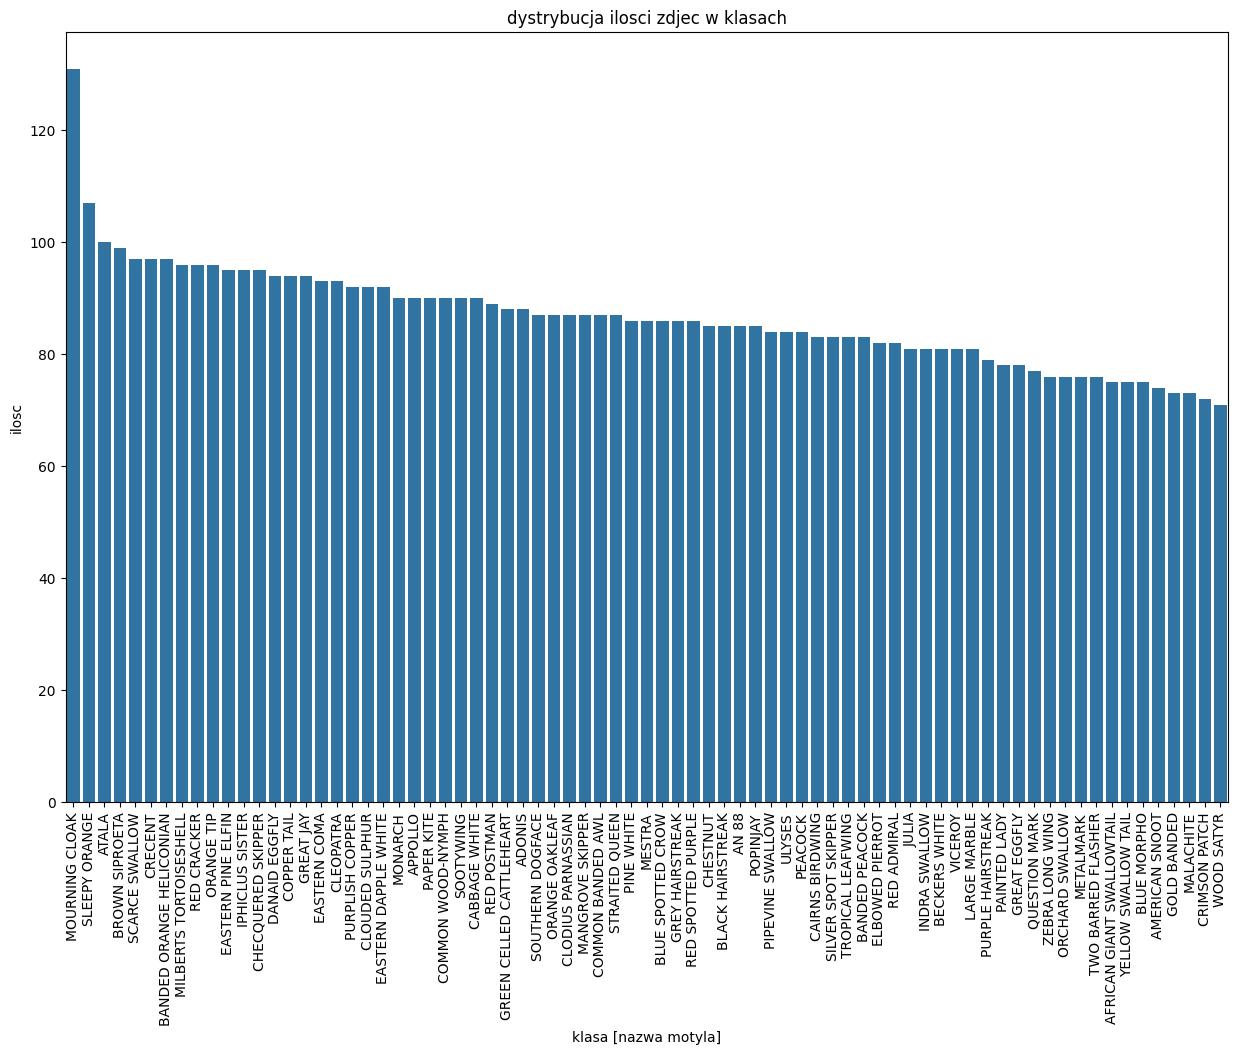

In [6]:
label_distribution = df['label'].value_counts()
plt.figure(figsize=(15, 10))
sns.barplot(x=label_distribution.index, y=label_distribution.values)
plt.title('dystrybucja ilosci zdjec w klasach')
plt.xlabel('klasa [nazwa motyla]')
plt.ylabel('ilosc')
plt.xticks(rotation=90)
plt.show()

In [4]:
def plot_training_history(history):

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

# KONFIGURACJA

In [5]:
img_height=150
img_width=150
BATCH_SIZE = 32
EPOCHS = 20
CLASSES = 75
DROPOUT_RATE = 0.3
LEARNING_RATE = 0.00005

# TRENOWANIE SIECI

## WCZYTYWANIE DANYCH

In [6]:
image_dir = "butterflies/train"

In [7]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, additional_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42) # podzielenie train_df na jeszcze mniejsze żeby później dodać additional do załadowania dodatkowych zdjęć :]

img_gen = ImageDataGenerator()

train = img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation = img_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

additional = img_gen.flow_from_dataframe(
    dataframe=additional_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 4159 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.
Found 1040 validated image filenames belonging to 75 classes.


In [8]:
class_count = len(train.class_indices)
class_count

75

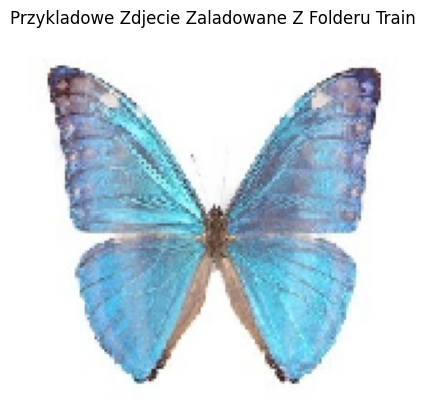

In [18]:
def sample_image():
  images, labels = next(train)

  plt.imshow(images[2].astype(np.uint8))
  plt.title(f"Przykladowe Zdjecie Zaladowane Z Folderu Train")
  plt.axis('off')
  plt.show()

sample_image()

## ResNet50 OD ZERA

In [9]:
base_model = ResNet50(include_top=False,
                      weights=None,
                      classes=class_count)

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,472 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, None,      │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, None,      │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, None,      │          0 │ conv2_block1_1_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, None,      │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, None,      │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, None,      │          0 │ conv2_block1_2_b… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, None,      │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, None,      │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, None,      │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ None, 256)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, None,      │      1,024 │ conv2_block1_3_c

 Total params: 23,741,387 (90.57 MB)

 Trainable params: 23,688,267 (90.36 MB)

 Non-trainable params: 53,120 (207.50 KB)

## CPU

In [46]:
train_sample_df = train_df.sample(n=500, random_state=42).reset_index(drop=True)
val_sample_df = val_df.sample(n=100, random_state=42).reset_index(drop=True)

In [47]:
all_classes = sorted(df['label'].unique().astype(str))

train_sample = img_gen.flow_from_dataframe(
    dataframe=train_sample_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=8,
    class_mode='categorical',
    classes=all_classes
)

val_sample = img_gen.flow_from_dataframe(
    dataframe=val_sample_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=8,
    class_mode='categorical',
    classes=all_classes
)


Found 500 validated image filenames belonging to 75 classes.
Found 100 validated image filenames belonging to 75 classes.


In [48]:
history = model.fit(train_sample, validation_data=val_sample, epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.0415 - loss: 4.7925 - val_accuracy: 0.0400 - val_loss: 4.6388
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.0674 - loss: 4.1439 - val_accuracy: 0.1000 - val_loss: 3.8429
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 215s 3s/step - accuracy: 0.0762 - loss: 3.8794 - val_accuracy: 0.0500 - val_loss: 4.0393
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.0875 - loss: 3.8791 - val_accuracy: 0.0800 - val_loss: 3.8950
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 214s 3s/step - accuracy: 0.1227 - loss: 3.6996 - val_accuracy: 0.0200 - val_loss: 55.0069
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.1016 - loss: 3.6622 - val_accuracy: 0.0400 - val_loss: 13.0730
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 203s 3s/step - accuracy: 0.1344 - loss: 3.4365 - val_accuracy: 0.0600 - val_loss: 8.7695
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.1435 - loss: 3.4615 - val_accuracy: 0.0400 - val_loss: 

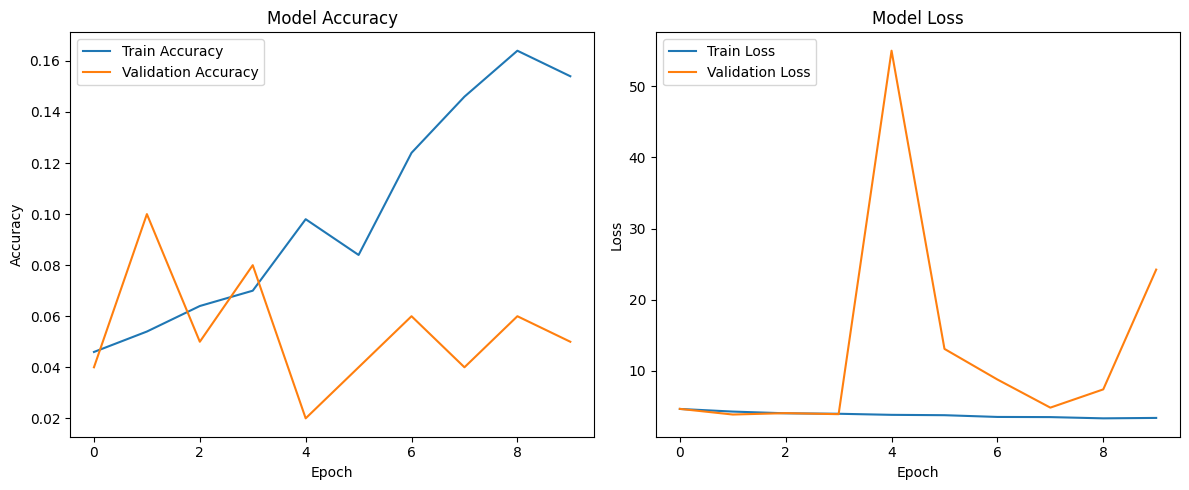

In [50]:
plot_training_history(history)

## GPU

In [10]:
history = model.fit(train, validation_data=validation, epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 110s 414ms/step - accuracy: 0.0278 - loss: 5.4771 - val_accuracy: 0.0162 - val_loss: 47.6850
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.1324 - loss: 3.5491 - val_accuracy: 0.0869 - val_loss: 12.5149
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.2366 - loss: 2.8751 - val_accuracy: 0.1985 - val_loss: 3.9893
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step - accuracy: 0.3259 - loss: 2.4446 - val_accuracy: 0.1623 - val_loss: 4.2218
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 25s 196ms/step - accuracy: 0.4195 - loss: 2.0848 - val_accuracy: 0.2877 - val_loss: 4.7004
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 197ms/step - accuracy: 0.4835 - loss: 1.7478 - val_accuracy: 0.2792 - val_loss: 3.3181
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 201ms/step - accuracy: 0.5500 - loss: 1.5434 - val_accuracy: 0.0962 - val_loss: 37.9575
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 40s 197ms/step - accuracy: 0.6049 - loss: 1.3565 -

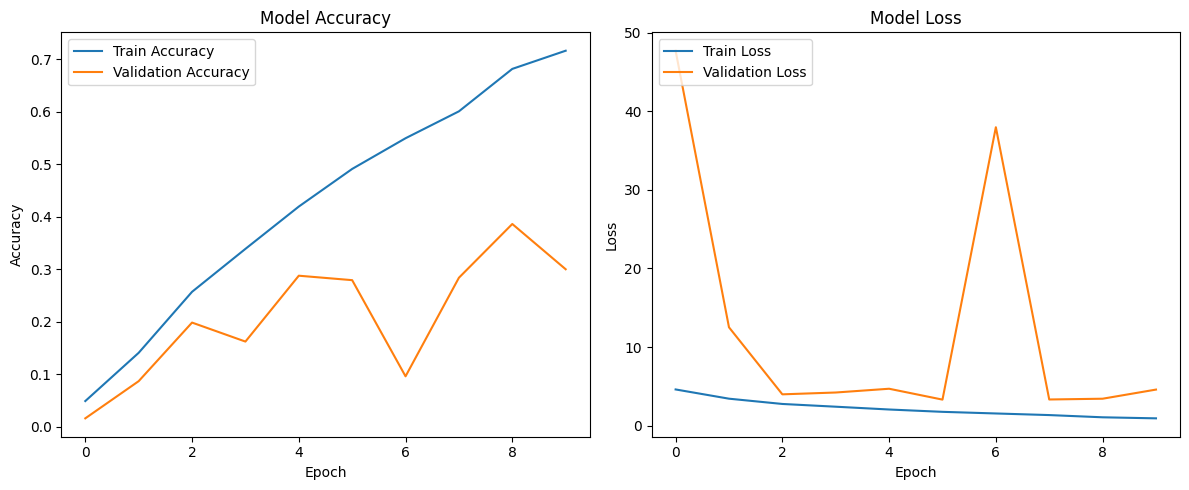

In [14]:
plot_training_history(history)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


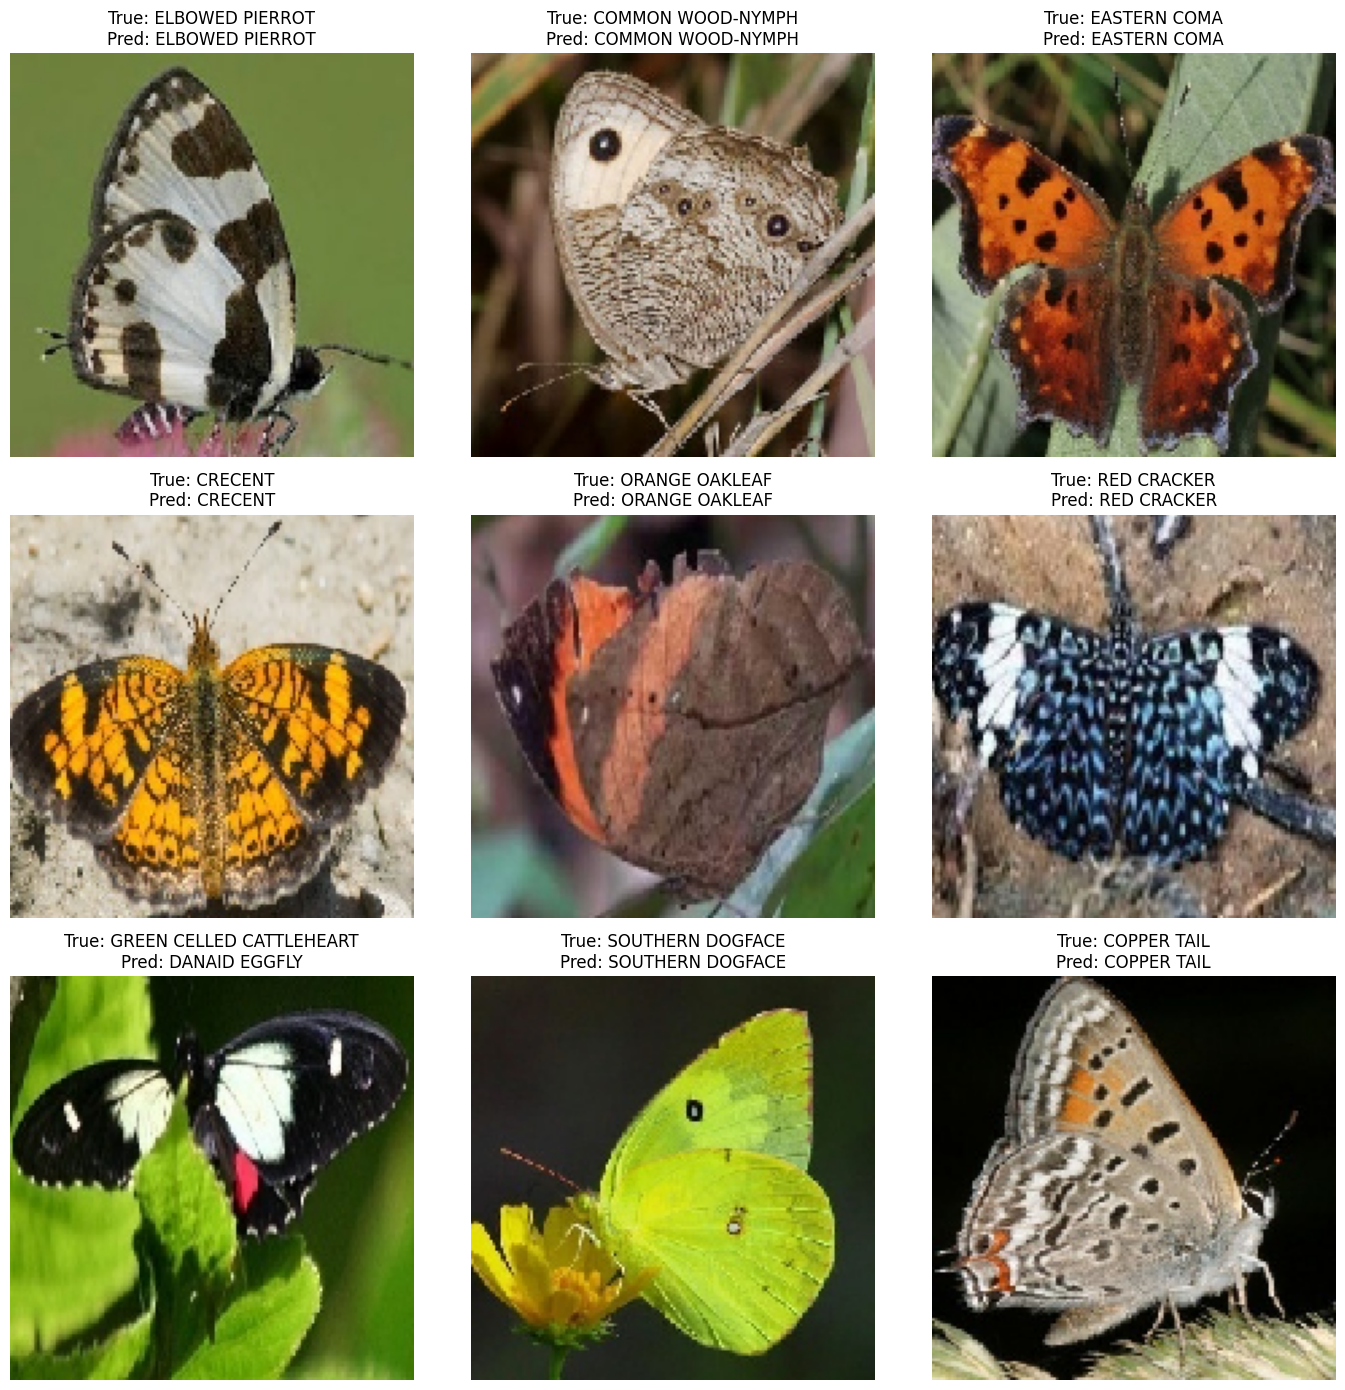

In [15]:
val_images, val_labels = next(validation)

pred_labels = model.predict(val_images)
pred_labels = np.argmax(pred_labels, axis=1)
true_labels = np.argmax(val_labels, axis=1)

class_indices = validation.class_indices
class_names = {v: k for k, v in class_indices.items()}

def display_images(images, true_labels, pred_labels, class_names, num_images=9):
    plt.figure(figsize=(14, 14))
    for i in range(num_images):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].astype(np.uint8))
        true_label = class_names[int(true_labels[i])]
        pred_label = class_names[int(pred_labels[i])]
        plt.title(f"True: {true_label}\nPred: {pred_label}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

display_images(val_images, true_labels, pred_labels, class_names, num_images=9)

# TRANSFER LEARNING

In [18]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 156, 156,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 75, 75,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 75, 75,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 75, 75,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 77, 77,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 38, 38,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 38, 38,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 38, 38,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 38, 38,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 38, 38,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 38, 38,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 38, 38,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 38, 38,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 38, 38,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 38, 38,    │      1,024 │ conv2_block1_3_c

 Total params: 23,741,387 (90.57 MB)

 Trainable params: 153,675 (600.29 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [19]:
history_tl = model.fit(train, validation_data=validation, epochs=10)

Epoch 1/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 130ms/step - accuracy: 0.0182 - loss: 5.1514 - val_accuracy: 0.0623 - val_loss: 4.1849
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.1047 - loss: 3.8783 - val_accuracy: 0.1954 - val_loss: 3.3980
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.2677 - loss: 3.0461 - val_accuracy: 0.3238 - val_loss: 2.8215
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.4160 - loss: 2.4741 - val_accuracy: 0.4408 - val_loss: 2.3951
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.5353 - loss: 2.0514 - val_accuracy: 0.5192 - val_loss: 2.0913
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - accuracy: 0.6247 - loss: 1.7431 - val_accuracy: 0.5654 - val_loss: 1.8570
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.6771 - loss: 1.4927 - val_accuracy: 0.6069 - val_loss: 1.6765
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.7055 - loss: 1.3288 - val

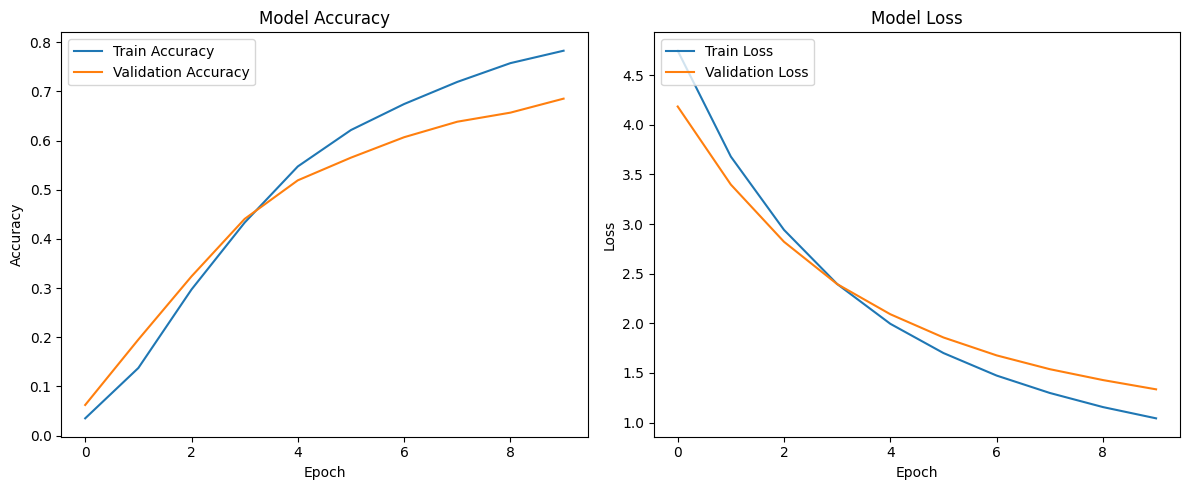

In [20]:
plot_training_history(history_tl)

# OPTYMALIZACJA

## a. normalizacja


In [32]:
from tensorflow.keras.applications.resnet50 import preprocess_input
# przekształca obrazy do takiego formatu, jakiego oczekuje wybrany model sieci

In [31]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, additional_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42) # podzielenie train_df na jeszcze mniejsze żeby później dodać additional do załadowania dodatkowych zdjęć :]

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

train = img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation = img_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

additional = img_gen.flow_from_dataframe(
    dataframe=additional_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 4159 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.
Found 1040 validated image filenames belonging to 75 classes.


In [34]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [35]:
history_nor = model.fit(train, validation_data=validation, epochs=10)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


130/130 ━━━━━━━━━━━━━━━━━━━━ 26s 131ms/step - accuracy: 0.0284 - loss: 4.9769 - val_accuracy: 0.0792 - val_loss: 3.9459
Epoch 2/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.1478 - loss: 3.6203 - val_accuracy: 0.2308 - val_loss: 3.1005
Epoch 3/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.3227 - loss: 2.8370 - val_accuracy: 0.4015 - val_loss: 2.4835
Epoch 4/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.4854 - loss: 2.2548 - val_accuracy: 0.5285 - val_loss: 2.0449
Epoch 5/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.6042 - loss: 1.8006 - val_accuracy: 0.6123 - val_loss: 1.7355
Epoch 6/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - accuracy: 0.6859 - loss: 1.5003 - val_accuracy: 0.6677 - val_loss: 1.5092
Epoch 7/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 77ms/step - accuracy: 0.7586 - loss: 1.2596 - val_accuracy: 0.7115 - val_loss: 1.3382
Epoch 8/10
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.7880 - loss: 1.1031 - val_accura

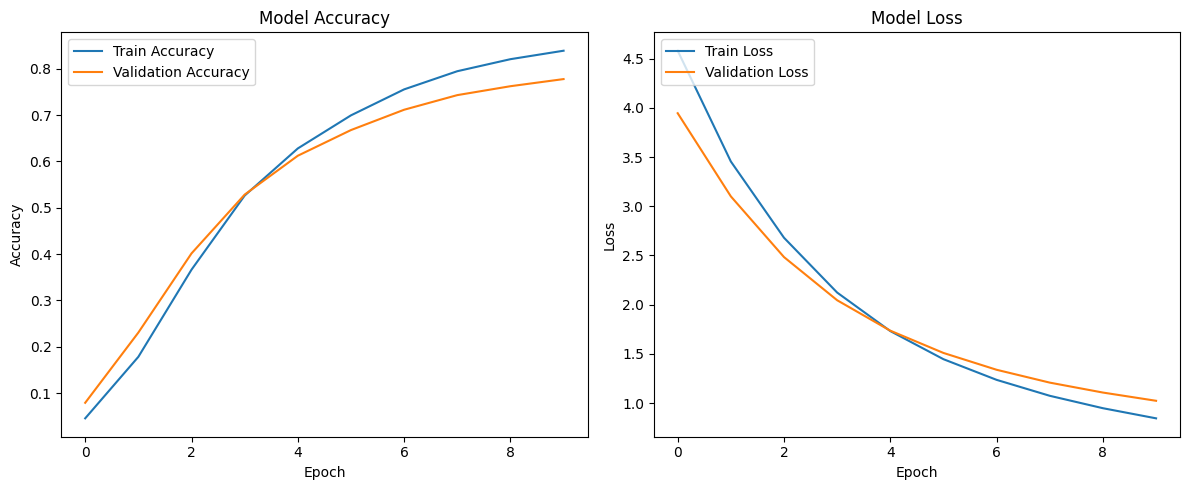

In [36]:
plot_training_history(history_nor)

## b. augumentacja danych

In [47]:
# augumentacja danych: polega na wprowadzeniu do materiału treningowego nieco zmodyfikowanych kopii istniejących danych:)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20, # randomly rotate images through any degree between 0 and 360
    width_shift_range=0.2, # horizontal shift of image
    height_shift_range=0.2, #  the percentage of width or height of the image to shift
    zoom_range=0.2, #  zooming in
    horizontal_flip=True, # flipping along the horizontal axis
    fill_mode='nearest' # “nearest” which simply replaces the empty area with the nearest pixel values
)

In [48]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
train_df, additional_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42) # podzielenie train_df na jeszcze mniejsze żeby później dodać additional do załadowania dodatkowych zdjęć :]


train = img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation = img_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

additional = img_gen.flow_from_dataframe(
    dataframe=additional_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 4159 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.
Found 1040 validated image filenames belonging to 75 classes.


In [52]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_au = model.fit(train, validation_data=validation, epochs=20, callbacks=[early_stop])

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 54s 340ms/step - accuracy: 0.0173 - loss: 5.0036 - val_accuracy: 0.0869 - val_loss: 4.0318
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 37s 283ms/step - accuracy: 0.1210 - loss: 3.8298 - val_accuracy: 0.2146 - val_loss: 3.2757
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 277ms/step - accuracy: 0.2564 - loss: 3.0658 - val_accuracy: 0.3631 - val_loss: 2.6647
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 278ms/step - accuracy: 0.4148 - loss: 2.4906 - val_accuracy: 0.4923 - val_loss: 2.2148
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - accuracy: 0.5200 - loss: 2.0937 - val_accuracy: 0.5569 - val_loss: 1.9469
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 280ms/step - accuracy: 0.6324 - loss: 1.7243 - val_accuracy: 0.6162 - val_loss: 1.6750
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 277ms/step - accuracy: 0.6714 - loss: 1.5258 - val_accuracy: 0.6608 - val_loss: 1.5066
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 278ms/step - accuracy: 0.7130 - loss: 1

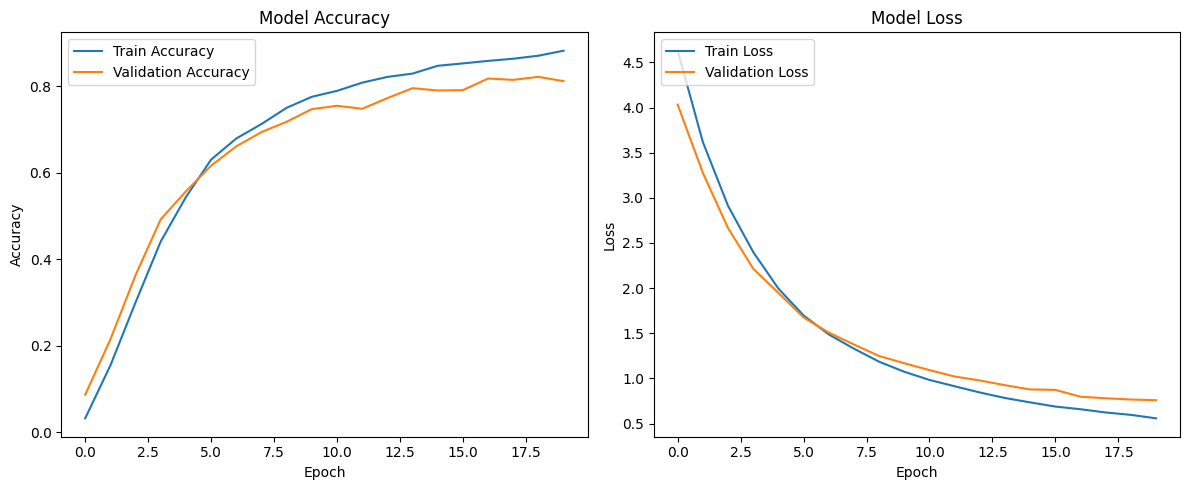

In [54]:
plot_training_history(history_au)

PARAMETRY ImageDataGenerator WYTŁUMACZONE

    preprocessing_function=preprocess_input -> normalizacja, przekształca obrazy tak, by pasowały do wymagań konkretnej sieci
    rotation_range=20, -> losowo obraca obraz w zakresie od -20 do +20 stopni
    width_shift_range=0.2, -> przesuwa obraz w poziomie o maksymalnie 20% szerokości
    height_shift_range=0.2, -> przesuwa obraz w pionie o maksymalnie 20% szerokości
    zoom_range=0.2, -> zoom, zbliżenie w zakresie 20%
    horizontal_flip=True, -> obrócienie obrazu poziomo
    fill_mode='nearest' -> “nearest” zamienia powstane puste piksele obrazu najbliższymi wartościami

## c. dropout

In [58]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dropout(0.3)(x) # losowo wyłącza część neuronów w trakcie trenowania

x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [59]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_dropout = model.fit(train, validation_data=validation, epochs=20, callbacks=[early_stop])

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 55s 344ms/step - accuracy: 0.0241 - loss: 5.5109 - val_accuracy: 0.0515 - val_loss: 4.2496
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 39s 297ms/step - accuracy: 0.0471 - loss: 4.5623 - val_accuracy: 0.1385 - val_loss: 3.5178
Epoch 3/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 275ms/step - accuracy: 0.1043 - loss: 3.8896 - val_accuracy: 0.2531 - val_loss: 3.0029
Epoch 4/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 275ms/step - accuracy: 0.1864 - loss: 3.3297 - val_accuracy: 0.3885 - val_loss: 2.5393
Epoch 5/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 276ms/step - accuracy: 0.2825 - loss: 2.8473 - val_accuracy: 0.4792 - val_loss: 2.1686
Epoch 6/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 275ms/step - accuracy: 0.3559 - loss: 2.4925 - val_accuracy: 0.5477 - val_loss: 1.9543
Epoch 7/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 275ms/step - accuracy: 0.4356 - loss: 2.2064 - val_accuracy: 0.6092 - val_loss: 1.7140
Epoch 8/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 275ms/step - accuracy: 0.4702 - loss: 1

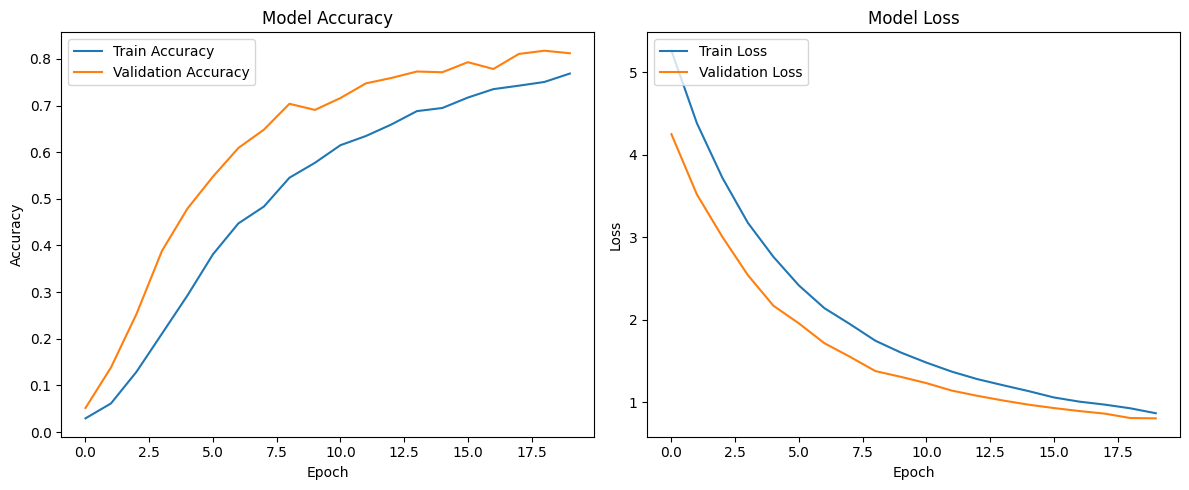

In [60]:
plot_training_history(history_dropout)

## d. dokładanie danych

In [66]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# train_df, additional_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20, # randomly rotate images through any degree between 0 and 360
    width_shift_range=0.2, # horizontal shift of image
    height_shift_range=0.2, #  the percentage of width or height of the image to shift
    zoom_range=0.2, #  zooming in
    horizontal_flip=True, # flipping along the horizontal axis
    fill_mode='nearest' # “nearest” which simply replaces the empty area with the nearest pixel values
)

train = img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation = img_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

"""
wyłączenie dodatkowego podziału danych żeby działało na większej ilośći zdjęć

additional = img_gen.flow_from_dataframe(
    dataframe=additional_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

"""

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


" \nwyłączenie dodatkowego podziału danych żeby działało na większej ilośći zdjęć\n\nadditional = img_gen.flow_from_dataframe(\n    dataframe=additional_df,\n    directory=image_dir,\n    x_col='filename',\n    y_col='label',\n    target_size=(img_height, img_width),\n    batch_size=BATCH_SIZE,\n    class_mode='categorical'\n)\n\n"

In [67]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dropout(0.3)(x) # losowo wyłącza część neuronów w trakcie trenowania

x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_add = model.fit(train, validation_data=validation, epochs=20, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 67s 340ms/step - accuracy: 0.0218 - loss: 5.5548 - val_accuracy: 0.0885 - val_loss: 4.0688
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 270ms/step - accuracy: 0.0741 - loss: 4.3590 - val_accuracy: 0.1954 - val_loss: 3.3086
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 310ms/step - accuracy: 0.1623 - loss: 3.5812 - val_accuracy: 0.3300 - val_loss: 2.7086
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 50s 309ms/step - accuracy: 0.2556 - loss: 2.9861 - val_accuracy: 0.4515 - val_loss: 2.2746
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 51s 315ms/step - accuracy: 0.3497 - loss: 2.5101 - val_accuracy: 0.5554 - val_loss: 1.9201
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 279ms/step - accuracy: 0.4402 - loss: 2.1501 - val_accuracy: 0.6238 - val_loss: 1.6910
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 270ms/step - accuracy: 0.4960 - loss: 1.9061 - val_accuracy: 0.6654 - val_loss: 1.5031
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 43s 263ms/step - accuracy: 0.5462 - loss: 1

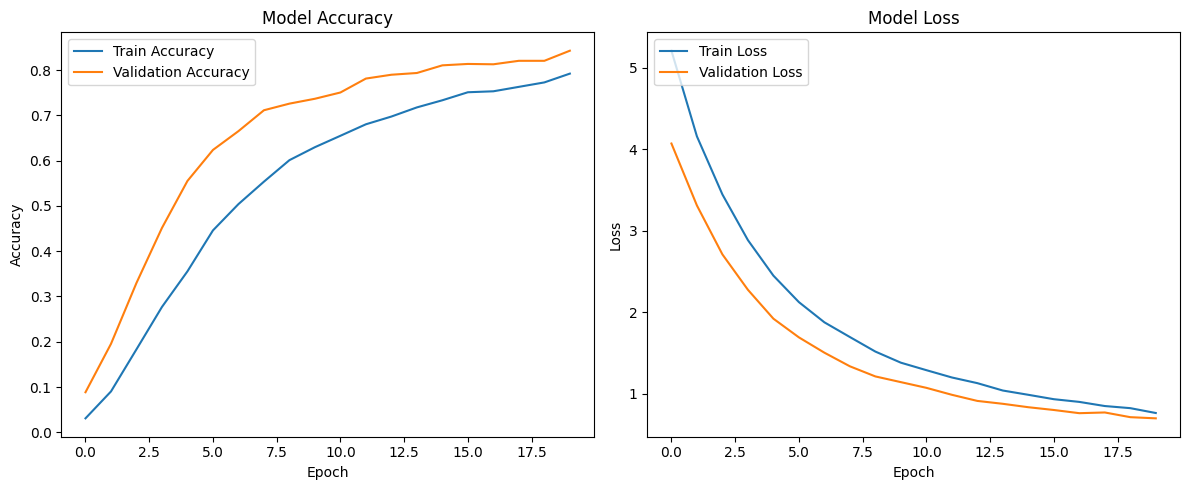

In [69]:
plot_training_history(history_add)

## e. różne rozmiary wejściowe

### 96x96

In [70]:
img_height=96
img_width=96

In [71]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train = img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation = img_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


In [72]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dropout(0.3)(x) # losowo wyłącza część neuronów w trakcie trenowania

x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [73]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_96x96 = model.fit(train, validation_data=validation, epochs=20, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 44s 205ms/step - accuracy: 0.0142 - loss: 8.8875 - val_accuracy: 0.0454 - val_loss: 5.5081
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.0445 - loss: 6.6478 - val_accuracy: 0.1315 - val_loss: 4.1801
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.1036 - loss: 5.2827 - val_accuracy: 0.2531 - val_loss: 3.2008
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.1764 - loss: 4.2382 - val_accuracy: 0.3454 - val_loss: 2.6539
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 139ms/step - accuracy: 0.2424 - loss: 3.6448 - val_accuracy: 0.4392 - val_loss: 2.1818
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 23s 140ms/step - accuracy: 0.3027 - loss: 3.1523 - val_accuracy: 0.4915 - val_loss: 1.9296
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 22s 135ms/step - accuracy: 0.3568 - loss: 2.8307 - val_accuracy: 0.5377 - val_loss: 1.7052
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 42s 141ms/step - accuracy: 0.4070 - loss: 2

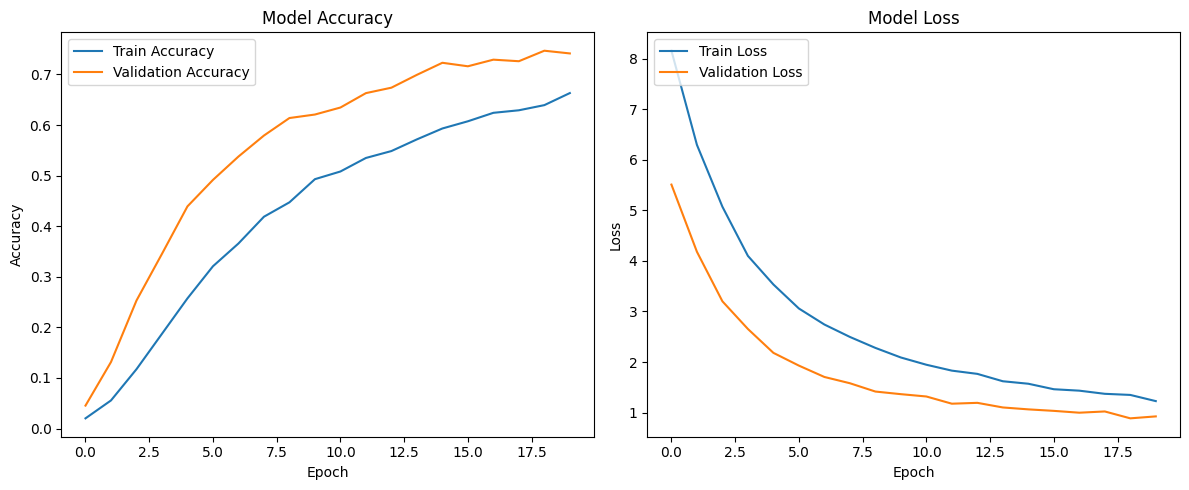

In [74]:
plot_training_history(history_96x96)

### 160x160

In [75]:
img_height=160
img_width=160
BATCH_SIZE=32

In [76]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train = img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation = img_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


In [77]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dropout(0.3)(x) # losowo wyłącza część neuronów w trakcie trenowania

x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [78]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_160x160 = model.fit(train, validation_data=validation, epochs=20, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 68s 353ms/step - accuracy: 0.0184 - loss: 5.5916 - val_accuracy: 0.0762 - val_loss: 4.0123
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 286ms/step - accuracy: 0.0667 - loss: 4.3145 - val_accuracy: 0.2277 - val_loss: 3.2633
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 291ms/step - accuracy: 0.1687 - loss: 3.5385 - val_accuracy: 0.3838 - val_loss: 2.6741
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 282ms/step - accuracy: 0.2497 - loss: 2.9822 - val_accuracy: 0.4938 - val_loss: 2.2158
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 287ms/step - accuracy: 0.3693 - loss: 2.4529 - val_accuracy: 0.5938 - val_loss: 1.8566
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 46s 285ms/step - accuracy: 0.4362 - loss: 2.1999 - val_accuracy: 0.6277 - val_loss: 1.6459
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 287ms/step - accuracy: 0.4755 - loss: 1.9546 - val_accuracy: 0.6800 - val_loss: 1.4577
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 47s 288ms/step - accuracy: 0.5600 - loss: 1

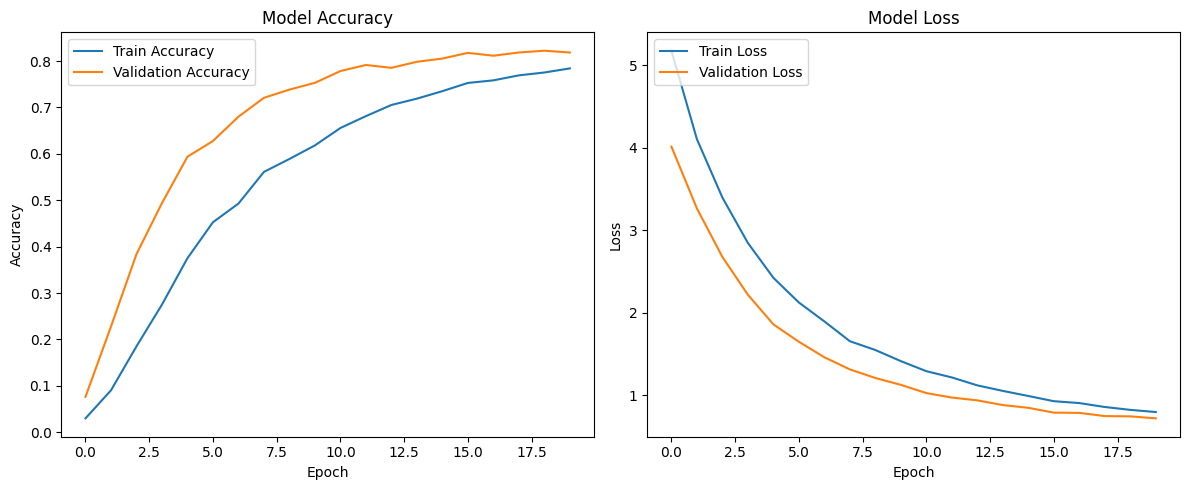

In [80]:
plot_training_history(history_160x160)

### 224x224

In [81]:
img_height=224
img_width=224

In [82]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train = img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation = img_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


In [83]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dropout(0.3)(x) # losowo wyłącza część neuronów w trakcie trenowania

x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [84]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_224x224 = model.fit(train, validation_data=validation, epochs=20, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 557ms/step - accuracy: 0.0149 - loss: 4.9898 - val_accuracy: 0.0738 - val_loss: 3.9889
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 84s 514ms/step - accuracy: 0.0655 - loss: 4.1473 - val_accuracy: 0.2046 - val_loss: 3.4130
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 511ms/step - accuracy: 0.1510 - loss: 3.5389 - val_accuracy: 0.3477 - val_loss: 2.9151
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 485ms/step - accuracy: 0.2648 - loss: 3.0134 - val_accuracy: 0.4723 - val_loss: 2.5374
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 80s 489ms/step - accuracy: 0.3646 - loss: 2.6234 - val_accuracy: 0.5662 - val_loss: 2.2182
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 481ms/step - accuracy: 0.4420 - loss: 2.3032 - val_accuracy: 0.6223 - val_loss: 1.9559
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 485ms/step - accuracy: 0.5036 - loss: 2.0780 - val_accuracy: 0.6846 - val_loss: 1.7442
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 78s 480ms/step - accuracy: 0.5511 - loss:

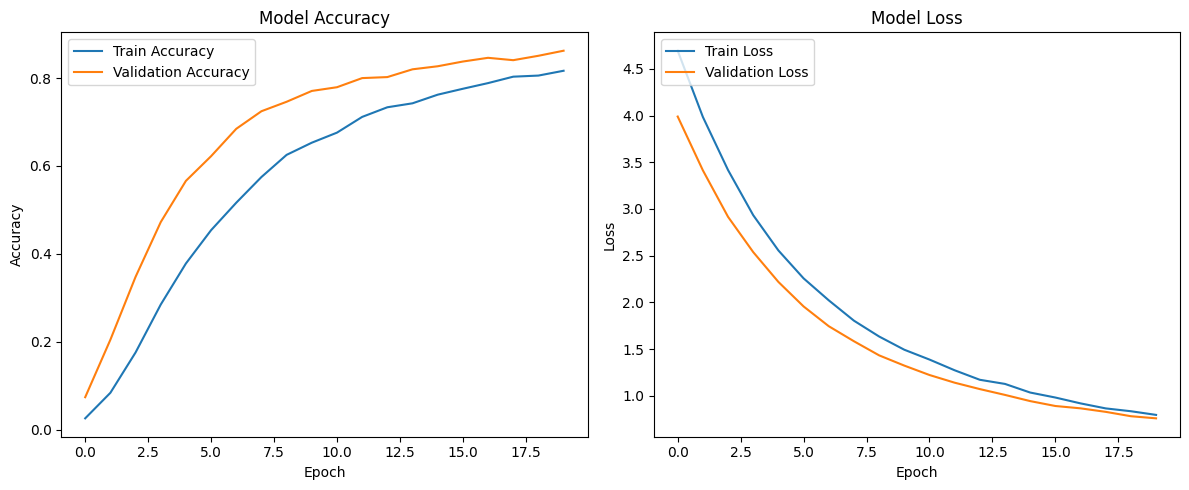

In [85]:
plot_training_history(history_224x224)

## f. różny rozmiar Batch size


### 16

In [91]:
img_height=224 # 224 gave the best accuracies
img_width=224
BATCH_SIZE=16 # 16 since i tried 32 beforee^

In [92]:
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

img_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train = img_gen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation = img_gen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_dir,
    x_col='filename',
    y_col='label',
    target_size=(img_height, img_width),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 5199 validated image filenames belonging to 75 classes.
Found 1300 validated image filenames belonging to 75 classes.


In [93]:
base_model = ResNet50(
    weights='imagenet', #transfer learning
    include_top=False,
    input_shape=(img_height, img_width, 3)
)

base_model.trainable = False #zamrozenie wag

x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)

x = tf.keras.layers.Dropout(0.3)(x) # losowo wyłącza część neuronów w trakcie trenowania

x = tf.keras.layers.Dense(75, activation='softmax')(x)
model = tf.keras.Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(0.00005), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_batch16 = model.fit(train, validation_data=validation, epochs=20, callbacks=[early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 111s 286ms/step - accuracy: 0.0231 - loss: 4.8193 - val_accuracy: 0.1338 - val_loss: 3.6712
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 127s 257ms/step - accuracy: 0.1126 - loss: 3.7453 - val_accuracy: 0.3577 - val_loss: 2.9601
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 85s 260ms/step - accuracy: 0.2729 - loss: 2.9551 - val_accuracy: 0.5177 - val_loss: 2.3815
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 83s 257ms/step - accuracy: 0.4021 - loss: 2.4557 - val_accuracy: 0.6346 - val_loss: 1.9958
Epoch 5/20
 70/325 ━━━━━━━━━━━━━━━━━━━━ 55s 219ms/step - accuracy: 0.5188 - loss: 2.0534

In [ ]:
plot_training_history(history_batch16)

### 64

In [ ]:
img_height=224
img_width=224
BATCH_SIZE=64

### 128

In [ ]:
img_height=224
img_width=224
BATCH_SIZE=128

## g. różne struktury sieci

### VGG16

### ResNet101

### InceptionV3

### MobileNet